In [17]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
sys.path.append('./include')
import ml4s
import json
from IPython.display import Image
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Quantum Many Body Problem
## Casey Sobecks
### Working from "Solving the Quantum Many Body Problem using Artificial Neural Networks" by Carleo and Troyer

The quantum many body problem is a general topic that covers many fields in Physics. It ranges from solid-state physics, superfluidity, molecular physics, atomic physics, nuclear structures, nuclear reactions, hadron spectroscopy, and quark-gluon plasma. [https://en.wikipedia.org/wiki/Many-body_problem] 

With this being so prevalent in all fields, it is beneficial to find a quick way to solve these systems. One method of interest is using an artificial neural network to solve the problem.

## Neural-Network Quantum States (NQS)
The problem above can be considered as a system with N discrete-valued degrees of freedom. These values can be anything, but in this case they will be spin. Denote these as $\mathcal{S}=(\mathcal{S}_1,\mathcal{S}_2 ... \mathcal{S}_{\mathcal{N}})$. In this system, the spins are restricted to be $\frac{1}{2}$ spin. The architecture of this system can be realized with a restricted Boltzmann machine. Graphically, the architecture is set up in the following image.

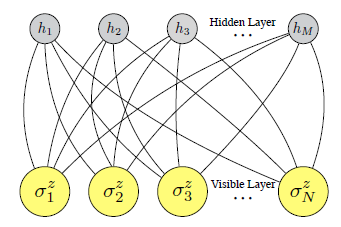

In [18]:
Image("fig1.png")

The neural network is composed of $\mathcal{N}$ visible layers and $\mathcal{M}$ hidden layers. The $\mathcal{N}$ layers represent the physical spin of the system. The $\mathcal{M}$ layers are auxilary spin variables, denoted in the figure as $(h_1...h_M)$. The variational expression for this system is given by the following equation.

$\Psi_M(\mathcal{S};\mathcal{W})=\sum_{\{h_i\}}\exp(\sum_j a_j \sigma_j^z+\sum_i b_i h_i + \sum_{ij} W_{ij} h_i \sigma_j^z)$

From this equation the weights can be defined as $\mathcal{W}=\{a_i,b_j,W_{ij}\}$. These weights fully specify the response of the network to some input state $\mathcal{S}$. In order to account for the amplitude and phase of the wave equation, the weights should be complex numbers. Since there are also no intra-layer interactions, the hidden variables can be explicitly traced out. This means that the variational equation can be simplified to the following equation.

$\Psi_M(\mathcal{S};\mathcal{W})=\exp(\sum_j a_j \sigma_j^z)\times \prod_{i=1}^M (2\cosh(b_i+\sum_j W_{ij} \sigma_j^z)$

This simplification will be very useful for the optimization of the weights.

## Stochastic Reconfiguration (SR)
In order to see how accuracte the NQS method is, a test can be constructed to find the ground state energy. To do these calculations, a quantum Hamiltonian is needed. The reference provides two different Hamiltonians. 

Transverse-field Ising: $\mathcal{H}_{TFI}=-h\sum_i \sigma_i^x-\sum_{<i,j>} \sigma_i^z \sigma_j^z$

Here, the left term is the spin of the current state and the right term is the spin of the neighboring states. The $\sigma$ terms are the usual pauli matrices. The constant h is a term that comes from the field and can be changed to test for different field strengths. According to the the paper, the hardest term to solve for is h=1, so this number will be avoided. The architecture of this Hamiltonian can be seen from a Markov Chain with periodic boundary conditions, shown in the following figure. 


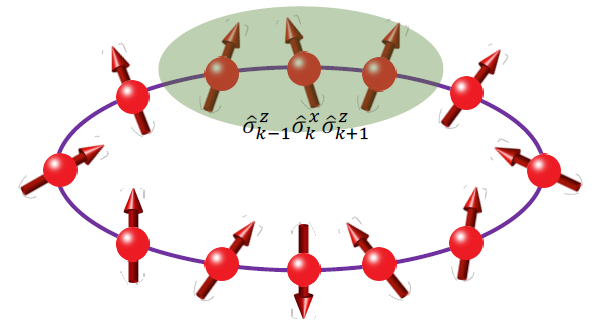

In [19]:
Image('fig2.png')

A second option that is given in the paper is the Anti ferromagnetic Heisenberg Hamiltonian, which is given by the following equations.

$\mathcal{H}_{AFH}=\sum_{<i,j>}\sigma_i^x \sigma_j^x +\sigma_i^y \sigma_j^y + \sigma_i^z \sigma_j^z$

where the sum is over the nearest neighbors. 

In order to do SR, the expectation value of the energy needs to be minimized with respect to the weights, $\mathcal{W}$. The energy expectation value is given by teh following equation.

$E(\mathcal{W})=\frac{<\Psi_M|\mathcal{H}|\Psi_M>}{<\Psi_M|\Psi_M>}$

and to minimize,

$\nabla_{\mathcal{W}}E(\mathcal{W})=0$

Further, the relative error of the energy that will be found from the NQS energy solution can be checked for accuracy if the exact energy is known. The equation for the relative error is defined as follows

$\epsilon_{rel}=\frac{E_{NQS}(\alpha)-E_{exact}}{|E_{exact}|}$

Here, the $\alpha$ term is the density of the hidden layer such that one can write $M=\alpha N$.

Previously in the course, we used an autodifferentiator(jax) to solve this kind of Stochastic Gradient Descent problem. This will not be possible here due to the complexity of the problem, so the derivatives will need to be manually computed.

In order to efficiently sample the wave function in order to update it stochastically, begin by rewriting it in the following way. 

$\Psi_M(\mathcal{S};\mathcal{W})=\exp(\sum_j a_j \sigma_j^z)\times \prod_{i=1}^M (2\cosh(\theta_j(\mathcal{S}))$

Where $\theta_j(\mathcal{S})$ is the effective angles and is defined as 

$\theta_j(\mathcal{S})=b_j+\sum_i W_{ij} \sigma_i^z$

From here, the derivative of the wave function can be taken with respect to each weight term. 

$\frac{1}{\Psi_M} \partial_{a_i} \Psi_M=\frac{1}{\Psi_M} 2\sigma_i^z \Psi_M=2\sigma_i^z$

$\frac{1}{\Psi_M} \partial_{b_j} \Psi_M=\frac{1}{\Psi_M} \exp(\sum_ia_i \sigma_i^z) \times \prod_{i \neq j}^M 2\cosh\theta_i \sinh\theta_j=\frac{1}{\Psi_M} \exp(\sum_ia_i \sigma_i^z) \times \prod_{i=1}^M 2\cosh\theta_i \frac{\sinh\theta_j}{\cosh\theta_j}=\frac{1}{\Psi_M} \tanh\theta_j \Psi_M=\tanh\theta_j$

$\frac{1}{\Psi_M} \partial_{W_{ij}} \Psi_M=\frac{1}{\Psi_M} \exp(\sum_ia_i \sigma_i^z) \times \prod_{i \neq j}^M 2\cosh\theta_i \sinh\theta_j \sigma_i^z=\frac{1}{\Psi_M} \exp(\sum_ia_i \sigma_i^z) \times \prod_{i=1}^M 2\cosh\theta_i \tanh\theta_j \sigma_i^z=\sigma_i^z\tanh\theta_j$

With these derivatives, the weights can be updated using stochastic gradient descent, which will include momentum in this project. 

Another portion of the SR procedure is to flip a random spin and check whether to update the states or to reject the new state. Choosing between the old state and the new state is done by analyzing hte probability of the acceptance. This is done in the reference material in the following manner.

$A(\mathcal{S}^{(k)} -> \mathcal{S}^{(k+1)})=min(1,\Biggr|\frac{\Psi_M(\mathcal{S}^{(k+1)})}{\Psi_M(\mathcal{S}^{(k)})}\Biggr|^2)$

## Cost 
A final comment needs to be made for the cost of the function. The method works by sweeping through $N$ locations and $M$ hidden layers each time. Therefore, the it is of order O($N \times M$)=O($\alpha N$). The reference paper uses a Markov chain of 40 points. This took far too long for my computer to run. 

## Code
To begin, set the number of sites, the density of the hidden layer $\alpha$, and the field $h$. Since the weights need to be complex, a random complex number function is needed.

In [20]:
def crand(N):
    x=(np.random.random(N)-0.5)*0.01
    y=(np.random.random(N)-0.5)*0.01
    z=x+1j*y
    return z   

In [21]:
N=14
alpha=2
h=2
M=alpha*N
a,b,W=crand(N),crand(M),crand((N,M))
S=np.random.randint(2,size=N)
S[S==0]=-1
S_i=list(range(N))

From here, the components of the wavefunction can be implemented.

In [22]:
def angle(S):
    theta=b+np.inner(np.transpose(W),S)
    return theta

In [23]:
def Psi_M(S,a,b,W):
    Psi=np.exp(np.inner(a,S))*np.prod(2*np.cosh(angle(S)))
    return Psi

The Hamiltonians can now be implemented. For this portion, the Transverse Field Ising will be used.

def E_loc(S):
    E=0
    #nearest neighbors, \sigma^z
    for i in S_i:
        if i==N-1: 
            E-=(S[i]*S[0])
        else: 
            E-=(S[i]*S[i+1])
    return E/N

In [24]:
def E_loc(S,a,b,W):
    E=0

    #nearest neighbors, \sigma^z
    for i in S_i:
        if i==N-1: 
            E-=(S[i]*S[0])
        else: 
            E-=(S[i]*S[i+1])
    
    #state spin, \sigma^x
    Psi_S=Psi_M(S,a,b,W)
    for i in S_i:
        #flip the spin of the state
        S[i]*=-1
        E-= -h*Psi_M(S,a,b,W)/Psi_S
        #flip back
        S[i]*=-1

    return E/N

def E_loc(S,a,b,W):
    E=0

    #nearest neighbors, \sigma^z
    for i in S_i:
        if i==N-1: 
            E=(S[i]*S[0])
        else: 
            E=(S[i]*S[i+1])
    
    #state spin, \sigma^x
    # Psi_S=Psi_M(S,a,b,W)
    # for i in S_i:
    #     #flip the spin of the state
    #     S[i]*=-1
    #     E-= -h*Psi_M(S,a,b,W)/Psi_S
    #     #flip back
    #     S[i]*=-1

    return E/N

To encode the probability of acceptance, need to first compute 

$\frac{\Psi_M(\mathcal{S}_{flip}) \Psi_M^*(\mathcal{S}_{flip})}{\Psi_M(\mathcal{S}_{current}) \Psi_M^*(\mathcal{S}_{current})}$

These flips should also be chosen are random so that the whole chain can be swept through.

In [25]:
def sweep():
    #choosing random site
    site=np.random.choice(S_i,1)
    Psi_i=Psi_M(S,a,b,W)
    #flip
    for i in site:
        S[i]*=-1
    
    Psi_f=Psi_M(S,a,b,W)
    A=np.real((Psi_f*np.conj(Psi_f))/(Psi_i*np.conj(Psi_i)))

    if A<np.random.uniform():
        #flip back
        for i in site:
            S[i]*=-1
        return 1 #this will be used to count flip rejections
    else: 
        return 0

During each sweep, the derivatives outlined above need to be taken. These are done with the following functions.

In [26]:
def a_deriv(N,S,h,a,b,W,Psi_S):
    a_d=np.zeros(N,dtype=np.complex_)
    for i in range(N):
        S[i]*=-1 #flip
        a_d[i]=-h*Psi_M(S,a,b,W)/Psi_S*S[i]*2
        S[i]*=-1 #flip back
    return a_d

In [27]:
def b_deriv(N,M,S,a,b,W,Psi_S):
    b_d=np.zeros(M,dtype=np.complex_)
    for i in range(M):
        tanh_i=np.tanh(angle(S))
        sum=0
        for j in range(N):
            S[j] *= -1
            sum+= Psi_M(S,a,b,W)/Psi_S*(np.tanh(angle(S)[i])-tanh_i[i])
            S[j] *= -1
        b_d[i]=-h*sum
    return b_d

In [28]:
def W_deriv(N,M,h,S,a,b,W,Psi_S):
    W_d=np.zeros((N,M),dtype=np.complex_)
    for i in range(N):
        for j in range(M):
            sum=0
            tanh_i=np.tanh(angle(S))
            for k in range(N):
                S[k]*=-1
                sum += Psi_M(S,a,b,W)/Psi_S*(-S[k]*np.tanh(angle(S)[j])-S[k]*tanh_i[j])
                S[k]*=-1
            sum*=h
            W_d[i,j]=sum
            
    return W_d

In [29]:
%%time 
E_ar=[]

#hyperparameters
rate=0.1
iterations=10000

for E_i in range(100):
    #set up the states of the space
    S=np.random.randint(2,size=N)
    S[S==0]=-1

    #iterate a few times before starting
    for i in range(2*iterations): 
        sweep()

    #variables
    
    rejected=0
    E_loc_aR=[]
    a_d_aR=[]
    b_d_aR=[]
    W_d_aR=[]

    #perform derivatives
    for i in range(iterations):
        rejected+=sweep()

        #only want to check derivative every 100 iterations
        if i%10==0:
            Psi_S=Psi_M(S,a,b,W)

            a_d_aR.append(a_deriv(N,S,h,a,b,W,Psi_S))
            b_d_aR.append(b_deriv(N,M,S,a,b,W,Psi_S))
            W_d_aR.append(W_deriv(N,M,h,S,a,b,W,Psi_S))
            E_loc_aR.append(np.real(E_loc(S,a,b,W)))
    
    E_ar.append(np.mean(E_loc_aR))
    
    a-=rate*np.mean(np.array(a_d_aR),axis=0)

    b-=rate*np.mean(np.array(b_d_aR),axis=0)

    W-=rate*np.mean(np.array(W_d_aR),axis=0)
    
    if E_i%10==0:
        print('%d. E_loc=%.4f std=%.4f with %.1f%% rejections'%(E_i+1,np.mean(E_loc_aR),np.std(E_loc_aR)/(np.sqrt(len(E_loc_aR))),100.*rejected/iterations))

1. E_loc=2.0010 std=0.0085 with 0.4% rejections
11. E_loc=0.1667 std=0.0084 with 6.7% rejections
21. E_loc=-1.9746 std=0.0084 with 6.8% rejections
31. E_loc=-1.9831 std=0.0090 with 11.8% rejections
41. E_loc=-1.9726 std=0.0089 with 12.2% rejections
51. E_loc=-1.9611 std=0.0091 with 14.4% rejections
61. E_loc=-1.9708 std=0.0092 with 15.5% rejections
71. E_loc=-1.9279 std=0.0095 with 20.1% rejections
81. E_loc=-1.9444 std=0.0098 with 19.4% rejections
91. E_loc=-1.9006 std=0.0095 with 22.5% rejections
Wall time: 5h 49min 46s


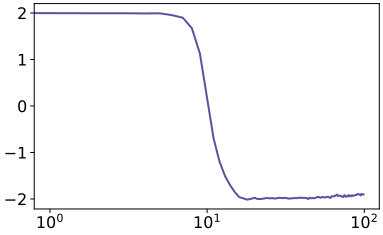

In [30]:
plt.semilogx(E_ar)

## Accuracy of the model

This model needs to be checked against the exact ground state energy to determine its accuracy. This is done with the following code which has been provided by [reference] 

In [15]:
%%time
from itertools import product

basis = list(product([-1,1],repeat=N))

print('Generated %d basis functions' % (len(basis)))
#print(len(basis_functions))

#list(permutations([0,1,0,0]))
H = np.zeros((2**N,2**N))
for H_i in range(2**N):
    for H_j in range(2**N):
        H_sum = 0
        for i in range(N):
            if H_i == H_j:
                if i == N-1:
                    H_sum -= basis[H_j][i]*basis[H_j][0]
                else:
                    H_sum -= basis[H_j][i]*basis[H_j][i+1]
                    
            sj = list(basis[H_j])
            sj[i] *= -1
            if H_i == basis.index(tuple(sj)):
                H_sum -= h

        H[H_i,H_j] = H_sum

E_exact=np.min(np.linalg.eigvals(H))/N
print('Ground state energy:', E_exact)

Generated 1024 basis functions
Ground state energy: (-2.1271208818696095+0j)


In [16]:
last=len(E_ar)-1
E_rel=(E_ar[E_i-1]-E_exact)/np.abs(E_exact)
print(E_rel)

(0.05745999865988966+0j)
